# Group connection test
In this tutorial, we demonstrate the use of the graspologic.inference module to compare the density of two networks, both of which contain nodes belonging to some known set of families or groups. The number and identity of the families or groups must be the same in the two networks. The group_connection_test function can then be used to determine whether there are any statistical differences in the group-to-group connection densities of the two networks, and whether there is a difference in the matrix of group-to-group connection densities. To do this, the user calls the function "group_connection_test" which can be imported from graspologic.inference. This function uses the stochastic block model, explained in greater detail below, to perform the density comparisons.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(8888)

from graspologic.inference.group_connection_test import group_connection_test
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm, rdpg
from graspologic.utils import symmetrize
from graspologic.plot import heatmap, pairplot

%matplotlib inline

## The stochastic block model (SBM)
A [**stochastic block model (SBM)**
](https://en.wikipedia.org/wiki/Stochastic_block_model)
is a popular statistical model of networks. Put simply, this model treats the
probability of an edge occuring between node $i$ and node $j$ as purely a function of
the *communities* or *groups* that node $i$ and $j$ belong to. Therefore, this model
is parameterized by:

   1. An assignment of each node in the network to a group. Note that this assignment
      can be considered to be deterministic or random, depending on the specific
      framing of the model one wants to use.
   2. A set of group-to-group connection probabilities

```{admonition} Math
Let $n$ be the number of nodes, and $K$ be the number of groups in an SBM. For a
network $A$ sampled from an SBM:

$$ A \sim SBM(B, \tau)$$

We say that for all $(i,j), i \neq j$, with $i$ and $j$ both running
from $1 ... n$ the probability of edge $(i,j)$ occuring is:

$$ P[A_{ij} = 1] = P_{ij} = B_{\tau_i, \tau_j} $$

where $B \in [0,1]^{K \times K}$ is a matrix of group-to-group connection
probabilities and $\tau \in \{1...K\}^n$ is a vector of node-to-group assignments.
Note that here we are assuming $\tau$ is a fixed vector of assignments, though other
formuations of the SBM allow these assignments to themselves come from a categorical
distribution.
```

## Testing under the SBM model
Assuming this model, there are a few ways that one could test for differences between
two networks. In this example, we are interested in comparing the group-to-group
connection probability matrices, $B$,  for the two graphs.

````{admonition} Math
We are interested in testing:

```{math}
:label: sbm_unmatched_null
H_0: B^{(L)} = B^{(R)}, \quad H_A: B^{(L)} \neq B^{(R)}
```

````

Rather than having to compare one proportion as in the density test, this test 
requires comparing all $K^2$ probabilities between the SBM models for both
networks.

```{admonition} Math
The hypothesis test above can be decomposed into $K^2$ indpendent hypotheses.
$B^{(L)}$
and $B^{(R)}$ are both $K \times K$ matrices, where each element $b_{kl}$ represents
the probability of a connection from a node in group $k$ to one in group $l$. We
also know that group $k$ for the left network corresponds with group $k$ for the
right. In other words, the *groups* are matched. Thus, we are interested in testing,
for $k, l$ both running from $1...K$:

$$ H_0: B_{kl}^{(L)} = B_{kl}^{(R)},
\quad H_A: B_{kl}^{(L)} \neq B_{kl}^{(R)}$$

```



To perform the comparison, the user provides the adjacency matrices and label vectors for both networks. In this example, we will generate random networks with known properties to demonstrate the use of the group_connection_test function.

First, we generate and plot an adjacency matrix representing a network with two groups and a specified array of group-to-group connection probabilities.

<AxesSubplot:title={'center':'2-block SBM adjacency matrix'}>

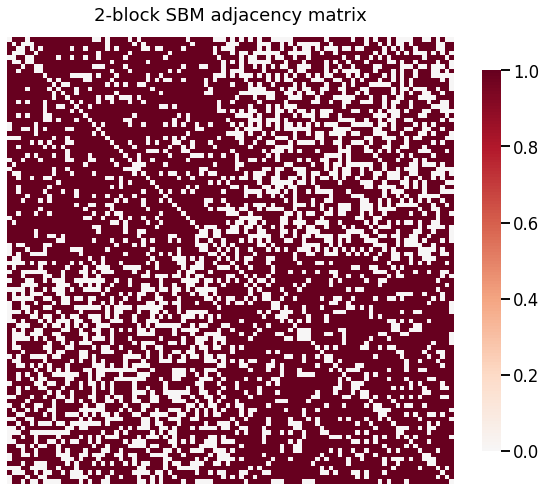

In [30]:
P = np.array([[0.8, 0.6],
              [0.6, 0.8]])
csize = [50] * 2
A1, labels1 = sbm(csize, P, return_labels = True)
heatmap(A1, title='2-block SBM adjacency matrix')


Next, we generate a second adjacency matrix for a second network. We will give this network a different number of nodes and a different connection probability matrix.

<AxesSubplot:title={'center':'2-block SBM adjacency matrix'}>

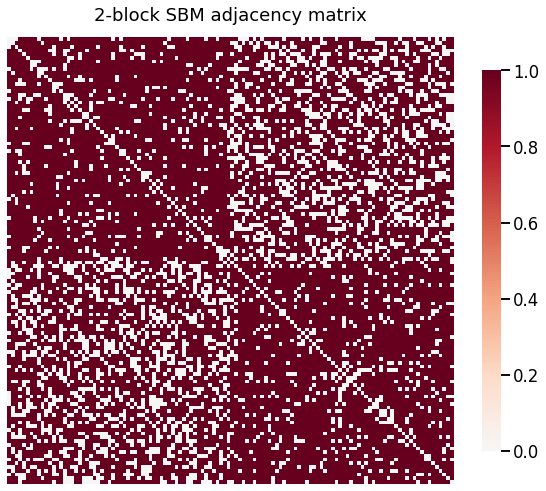

In [36]:
P = np.array([[0.865, 0.66],
              [0.66, 0.865]])
csize = [60] * 2
A2, labels2 = sbm(csize, P, return_labels = True)
heatmap(A2, title='2-block SBM adjacency matrix')

Now, we can run group_connection_test to assess whether there is a statistical difference between these two networks. Of course, we expect that there will be as, by design, their group-to-group connection densities are different.

In [37]:
stat, pvalue, misc = group_connection_test(A1, A2,labels1,labels2, combine_method="fisher")
print(pvalue)

4.591214411751736e-31


This extremely low p value suggests that we should reject the null hypothesis and conclude that the two networks are statistically different. The individual p values for each group-to-group connection are also extremely low:

In [38]:
print(misc["uncorrected_pvalues"])

target             0             1
source                            
0       2.362867e-11  6.865520e-08
1       6.865520e-08  4.435763e-11


But what if the densities of the two networks are actually related, even if they are not equal? In particular, what if the densities of the group-to-group connections are a fixed multiple of one another (e.g. the densities in network 2 are a fixed multiple of those in network 1)?

We can test for such a difference using group connection test by passing the argument "density_adjustment = True".

In [39]:
stat, pvalue, misc = group_connection_test(A1, A2,labels1,labels2, combine_method="fisher", density_adjustment= True)
print(pvalue)

0.15560876473852495


We now see a much higher p-value, greater than the conventional 0.05 cutoff for statistical significance. Thus, we fail to reject our adjusted null hypothesis, that the group-to-group connection densities are a scalar multiple of one another.

In [ ]:
print(misc["uncorrected_pvalues"])

## Adjusting for a difference in density
From {numref}`Figure {number} <fig:sbm_unmatched_test-sbm_uncorrected>`, we see that
we have sufficient evidence to reject
the null hypothesis of bilateral symmetry under this version of the SBM. However,
we already saw in [](er_unmatched_test) that the overall
densities between the two networks are different. Could it be that this rejection of
the null hypothesis under the SBM can be explained purely by this difference in
density? In other words, are the group-to-group connection probabilities on the right
simply a "scaled up" version of those on the right, where each probability is scaled
by the same amount? With graspologic.symmetry, you can answer this question, as it 
allows you to test a null hypothesis that one network's density is a fixed multiple of
the other network's density. To do this, when calling the group_connection_test function,
include the argument "density_adjustment=True". The function will then test whether the
densities of the group-to-group connections, and the overall network density for one network
are a fixed multiple of those of the other network. 

In {numref}`Figure {number} <fig:sbm_unmatched_test-probs_uncorrected>`,
we plot the estimated
probabilities on the left and the right hemispheres (i.e. each element of $\hat{B}$),
as
well as the difference between them. While subtle, we note that there is a slight
tendency for the left hemisphere estimated probability to be lower than the
corresponding one on the right. Specifically, we can also look at the group-to-group
connection probabilities which were significantly different in
{numref}`Figure {number} <fig:sbm_unmatched_test-sbm_uncorrected>` - these are plotted
in {numref}`Figure {number} <fig:sbm_unmatched_test-significant_p_comparison>`. Note
that in every case, the estimated probability on the right is higher with that on the
right.


```{glue:figure} fig:sbm_unmatched_test-probs_uncorrected
:name: "fig:sbm_unmatched_test-probs_uncorrected"

Comparison of estimated connection probabilities for the left and right hemispheres.
**A)** The estimated group-to-group connection probabilities ($\hat{p}$), sorted by
the mean left/right connection probability. Note the very subtle tendency for the
left probability to be lower than the corresponding one on the right. **B)** The
differences between corresponding group-to-group connection probabilities
($\hat{p}^{(L)} - \hat{p}^{(R)}$). The trend of the left connection probabilities
being slightly smaller than the corresponding probability on the right is more
apparent here, as there are more negative than positive values.
```

In [10]:


def plot_significant_probabilities(misc):
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    null_odds = misc["null_ratio"]
    B2 = B2 * null_odds
    index = B1.index
    uncorrected_pvalues = misc["uncorrected_pvalues"]
    n_tests = misc["n_tests"]

    alpha = 0.05
    hb_thresh = alpha / n_tests
    significant = uncorrected_pvalues < hb_thresh

    row_inds, col_inds = np.nonzero(significant.values)

    rows = []
    for row_ind, col_ind in zip(row_inds, col_inds):
        source = index[row_ind]
        target = index[col_ind]
        left_p = B1.loc[source, target]
        right_p = B2.loc[source, target]
        pair = source + r"$\rightarrow$" + "\n" + target
        rows.append(
            {
                "source": source,
                "target": target,
                "p": left_p,
                "side": "Left",
                "pair": pair,
            }
        )
        rows.append(
            {
                "source": source,
                "target": target,
                "p": right_p,
                "side": "Right",
                "pair": pair,
            }
        )
    sig_data = pd.DataFrame(rows)

    mean_ps = sig_data.groupby("pair")["p"].mean()
    pair_orders = mean_ps.sort_values(ascending=False).index

    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    sns.pointplot(
        data=sig_data,
        y="p",
        x="pair",
        ax=ax,
        hue="side",
        hue_order=["Right", "Left"],
        order=pair_orders,
        dodge=False,
        join=False,
        palette=network_palette,
        markers="_",
        scale=1.75,
    )
    ax.tick_params(axis="x", length=7)

    ax.set_yscale("log")
    ax.set_ylim((0.01, 1))

    leg = ax.get_legend()
    leg.set_title("Hemisphere")
    leg.set_frame_on(True)
    rotate_labels(ax)
    ax.set(xlabel="Group pair", ylabel="Connection probability")
    return fig, ax


fig, ax = plot_significant_probabilities(misc)
gluefig("significant_p_comparison", fig)

/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9882352941176471, 0.5529411764705883, 0.3843137254901961)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.4, 0.7607843137254902, 0.6470588235294118)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


```{glue:figure} fig:sbm_unmatched_test-significant_p_comparison
:name: "fig:sbm_unmatched_test-significant_p_comparison"

Comparison of estimated group-to-group connection probabilities for the group-pairs
which were significantly different in
{numref}`Figure {number} <fig:sbm_unmatched_test-sbm_uncorrected>`.
In each case, the connection probability on the right hemisphere is higher.
```

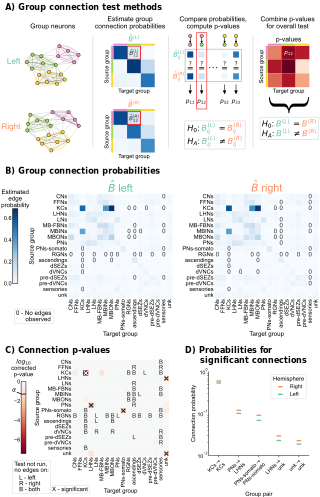

In [11]:

fontsize = 8

methods = SmartSVG(FIG_PATH / "sbm_methods_explain.svg")
methods.set_width(400)
methods.move(0, 15)
methods_panel = Panel(
    methods,
    Text("A) Group connection test methods", 5, 10, size=fontsize, weight="bold"),
)

probs = SmartSVG(FIG_PATH / "sbm_uncorrected.svg")
probs.set_width(400)
probs.move(0, 15)
probs_panel = Panel(
    probs,
    Text(
        "B) Group connection probabilities",
        5,
        10,
        size=fontsize,
        weight="bold",
    ),
)
probs_panel.move(0, methods.height * 0.9)

pvalues = SmartSVG(FIG_PATH / "sbm_uncorrected_pvalues.svg")
pvalues.set_width(200)
pvalues.move(10, 15)
pvalues_panel = Panel(
    pvalues, Text("C) Connection p-values", 5, 10, size=fontsize, weight="bold")
)
pvalues_panel.move(0, (methods.height + probs.height) * 0.9)

comparison = SmartSVG(FIG_PATH / "significant_p_comparison.svg")
comparison.set_width(150)
comparison.move(10, 25)
comparison_panel = Panel(
    comparison,
    Text("D) Probabilities for", 5, 10, size=fontsize, weight="bold"),
    Text("significant connections", 20, 20, size=fontsize, weight="bold"),
)
comparison_panel.move(pvalues.width * 0.9, (methods.height + probs.height) * 0.9)

fig = Figure(
    methods.width * 0.8,
    (methods.height + probs.height + pvalues.height) * 0.9,
    methods_panel,
    probs_panel,
    pvalues_panel,
    comparison_panel,
)

fig.save(FIG_PATH / "sbm_uncorrected_composite.svg")
fig

In [12]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:31.938121
Completed at 2022-04-13 16:43:31.447942
